## 0. 导入原音频

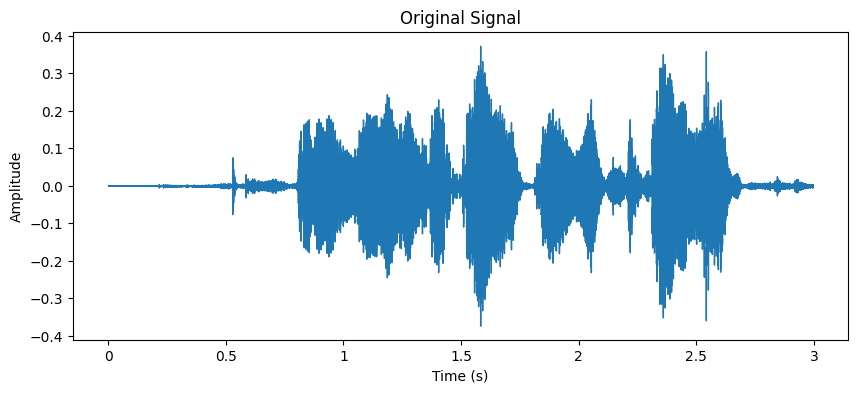

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

output_filename = "record.wav"

signal, fs = librosa.load(output_filename, sr=None)

# 可视化
plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=fs)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Original Signal')
plt.show()


## 1. 预加重
预加重是一个简单的高通滤波器，用于增加语音信号的高频能量，从而使语音信号的高频部分与低频部分具有相似的幅度。这是为了弥补语音信号中的高频损失，并提高MFCC的性能。

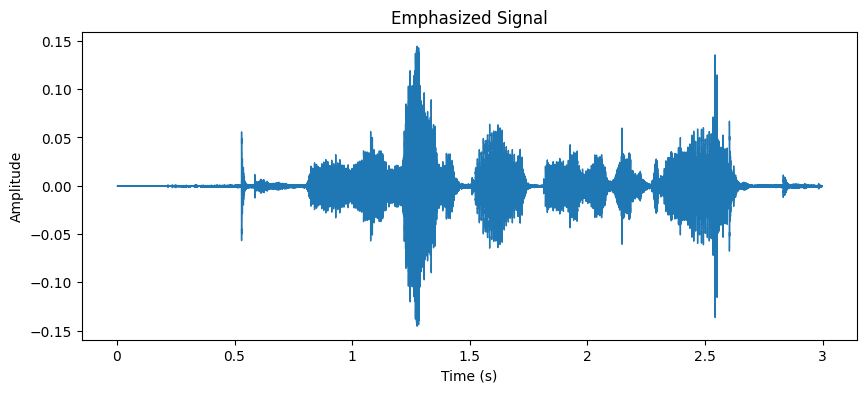

In [2]:
def pre_emphasis(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

emphasized_signal = pre_emphasis(signal)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(emphasized_signal, sr=fs)
plt.title('Emphasized Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()


## 2.窗口化
在窗口化阶段，连续的语音信号被划分为短的帧，每一帧都乘以一个窗口函数（如汉明窗）。这是为了确保帧的开始和结束处的连续性，并减少DFT（离散傅里叶变换）引入的频谱泄漏。

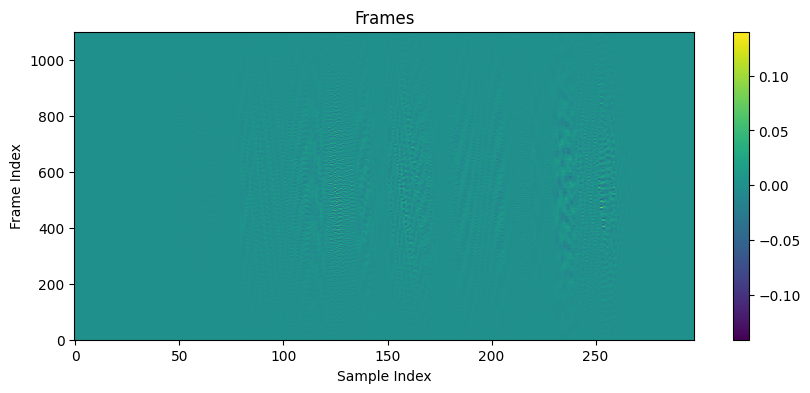

In [3]:
def framing(signal, frame_size, frame_stride, fs):
    # 修复这里，确保得到整数值
    frame_length, frame_step = frame_size * fs, frame_stride * fs  
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    signal_length = len(signal)
    frame_length = int(frame_length)
    frame_step = int(frame_step)
    total_frames = int(np.ceil(float(np.abs(signal_length - frame_length) / frame_step)))

    
    padded_signal_length = int(total_frames * frame_step + frame_length)
    zeros = np.zeros((padded_signal_length - len(signal)))
    padded_signal = np.append(signal, zeros)
    # 得到每一帧的开始索引
    # [1,frame_length]->[total_frames, frame_length]
    indices = np.tile(np.arange(0, frame_length), (total_frames, 1)) + np.tile(np.arange(0, total_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = padded_signal[indices.astype(np.int32, copy=False)]
    
    # 使用汉宁窗
    frames *= np.hamming(frame_length)
    return frames

frames = framing(emphasized_signal, 0.025, 0.01, fs)

plt.figure(figsize=(10, 4))
plt.imshow(frames.T, aspect='auto', cmap='viridis')
plt.title('Frames')
plt.ylabel('Frame Index')
plt.gca().invert_yaxis()  # 翻转y轴
plt.xlabel('Sample Index')
plt.colorbar()
plt.show()

## 3.短时傅立叶变换 (STFT)
短时傅立叶变换（STFT）是一个从时域到频域的转换工具，用于分析音频信号的频率组成。通过将连续的信号分割成短的帧并分别对它们应用傅立叶变换，我们可以得到每个帧的频谱。这个频谱揭示了在特定时间段内哪些频率是活跃的。对于语音，这意味着我们能够追踪其随时间变化的频率内容，使STFT成为一个极其有价值的工具。

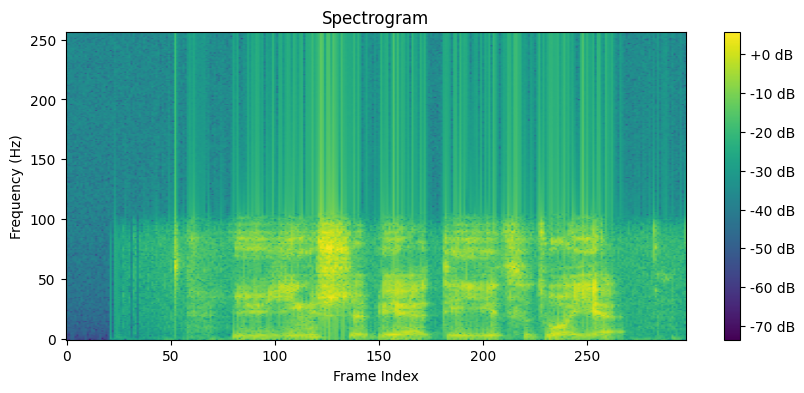

In [4]:
def stft(frames, NFFT):
    return np.abs(np.fft.rfft(frames, NFFT))

NFFT = 512
spectrum = stft(frames, NFFT)

plt.figure(figsize=(10, 4))
plt.imshow(10 * np.log10(spectrum.T), aspect='auto', cmap='viridis')
plt.title('Spectrogram')
plt.ylabel('Frequency (Hz)')
plt.gca().invert_yaxis()  # 翻转y轴
plt.xlabel('Frame Index')
plt.colorbar(format='%+2.0f dB')
plt.show()


## 4.梅尔滤波器组
梅尔滤波器组用于模拟人类听觉系统在频率识别上的非线性特性，特别是在较低频率下的更高的分辨率。这组滤波器在梅尔频率尺度上均匀分布，与线性频率尺度相比，梅尔尺度更接近于人类对频率的主观感知。每个滤波器在其中心频率有最大的响应，响应随着与中心频率的距离增加而减少。这模拟了我们的听觉系统对接近的频率更为敏感，而对远离的频率则不那么敏感的特性。通过这种方式，梅尔滤波器组提供了一个更接近人类听觉感知的音频信号的频率表示。

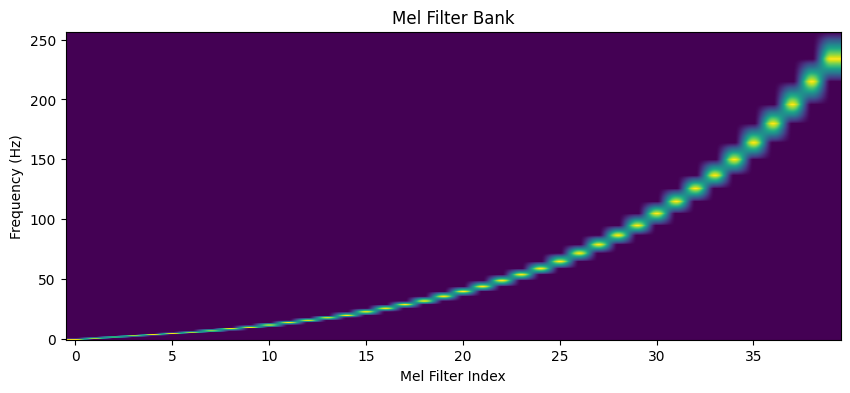

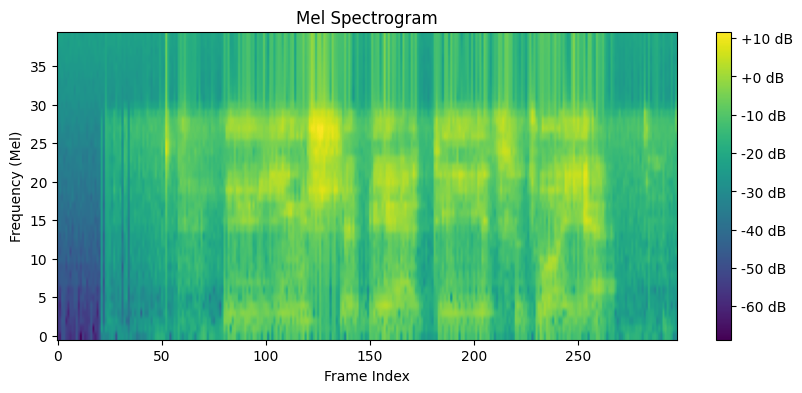

In [5]:
def mel_filter_bank(num_filters, NFFT, fs):
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin_points = np.floor((NFFT + 1) * hz_points / fs).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(NFFT / 2 + 1))))
    
    for i in range(1, num_filters + 1):
        filters[i - 1, bin_points[i - 1]:bin_points[i]] = (np.arange(bin_points[i] - bin_points[i - 1]) / (bin_points[i] - bin_points[i - 1]))
        filters[i - 1, bin_points[i]:bin_points[i + 1]] = 1 - (np.arange(bin_points[i + 1] - bin_points[i]) / (bin_points[i + 1] - bin_points[i]))

    return filters

filters = mel_filter_bank(40, NFFT, fs)

plt.figure(figsize=(10, 4))
plt.imshow(filters.T, aspect='auto', cmap='viridis')
plt.title('Mel Filter Bank')
plt.ylabel('Frequency (Hz)')
plt.gca().invert_yaxis()  # 翻转y轴
plt.xlabel('Mel Filter Index')
plt.show()

mel_spectrum = np.dot(spectrum, filters.T)

plt.figure(figsize=(10, 4))
plt.imshow(10 * np.log10(mel_spectrum.T), aspect='auto', cmap='viridis')
plt.title('Mel Spectrogram')
plt.ylabel('Frequency (Mel)')
plt.gca().invert_yaxis()  # 翻转y轴
plt.xlabel('Frame Index')
plt.colorbar(format='%+2.0f dB')
plt.show()


## 5.取对数
取对数操作确实是为了模拟人耳的感知特性。我们的听觉系统在对响度或振幅的感知上是对数的，意味着当声音的实际强度翻倍时，我们并不会感到响度增加了一倍。因此，通过应用对数操作，我们可以更接近地模拟人的听觉感知。对梅尔滤波器组的输出进行对数操作后，得到的结果称为log Mel spectrum，它为MFCC（梅尔频率倒谱系数）的提取提供了基础。这些MFCC系数经常用于语音和音频处理任务，因为它们为音频信号提供了一个与人类听觉更为相似的表示。

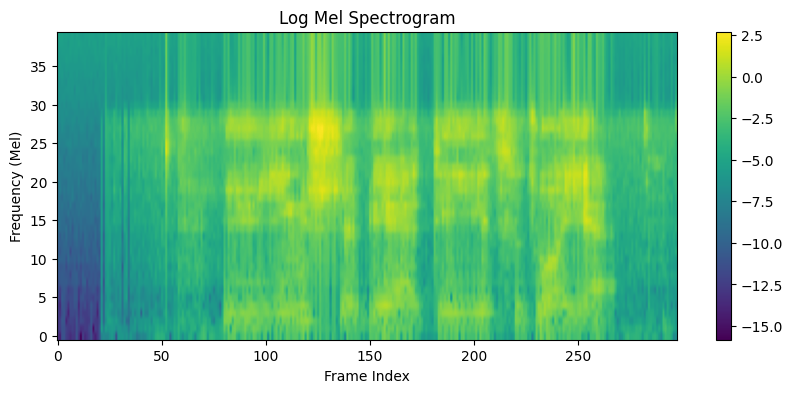

In [6]:
def log_magnitude(x):
    return np.log(x + 1e-10)

log_mel_spectrum = log_magnitude(mel_spectrum)

plt.figure(figsize=(10, 4))
plt.imshow(log_mel_spectrum.T, aspect='auto', cmap='viridis')
plt.title('Log Mel Spectrogram')
plt.ylabel('Frequency (Mel)')
plt.gca().invert_yaxis()  # 翻转y轴
plt.xlabel('Frame Index')
plt.colorbar()
plt.show()


## 6.离散余弦变换 (DCT)
在语音信号处理中，梅尔频率倒谱系数（MFCC）已被广泛采纳为主导特征。对梅尔滤波器组的输出进行离散余弦变换（DCT）产生了这些系数。DCT旨在最小化特征之间的相关性，并有效地压缩了语音信息。实践中，仅选取DCT的前几个系数，因为它们包含了语音信号的主要能量，而高阶系数往往与微细变化和噪声相关联。这种方法不仅简化了表示，还确保了特征的鲁棒性。

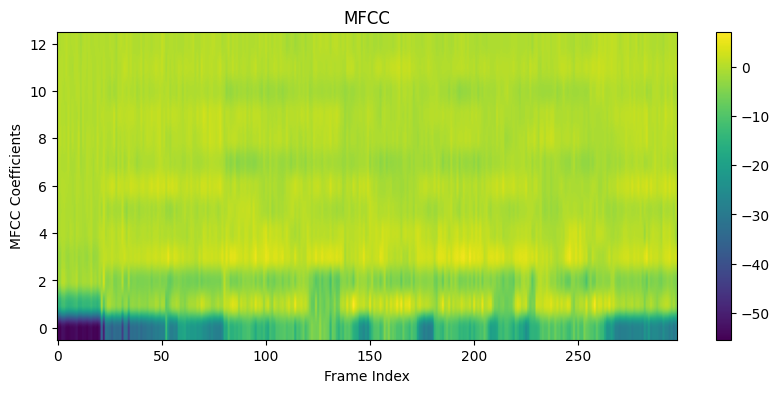

In [7]:
from scipy.fftpack import dct

mfcc_features = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :13]

plt.figure(figsize=(10, 4))
plt.imshow(mfcc_features.T, aspect='auto', cmap='viridis')
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')
plt.gca().invert_yaxis()  # 翻转y轴
plt.xlabel('Frame Index')
plt.colorbar()
plt.show()


## 7.动态特征提取
动态特征提取是音频信号处理中常用的一种方法，主要是为了捕获音频信号的时间动态特性。基于时间的一阶和二阶导数是提取这些动态特性的常用手段，这些导数也称为 delta（一阶导数）和 delta-delta（二阶导数）特征。

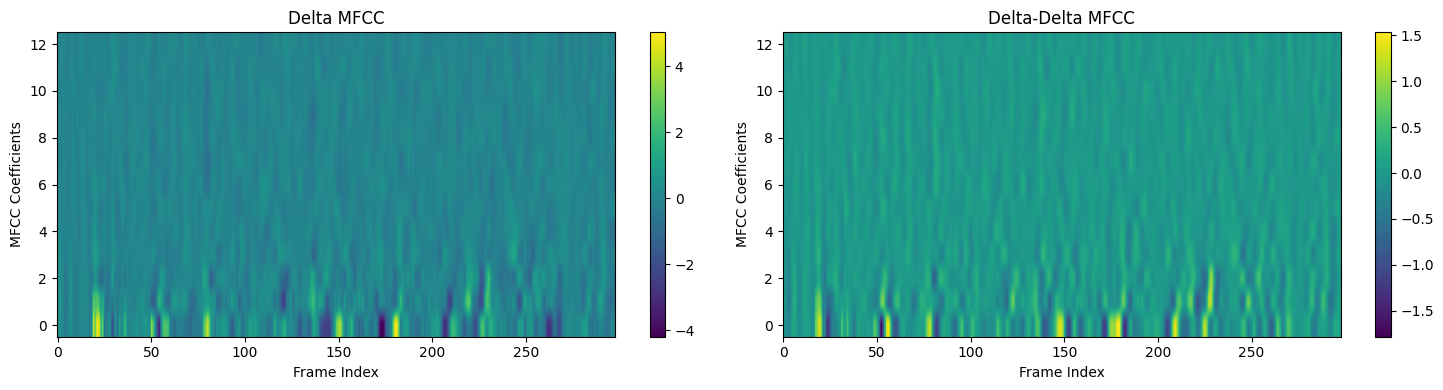

In [8]:
def delta(feature_matrix, N=2):
    num_frames, num_coeffs = feature_matrix.shape
    denominator = 2 * sum([i**2 for i in range(1, N+1)])
    delta_feature = np.empty_like(feature_matrix)
    
    padded = np.pad(feature_matrix, ((N, N), (0, 0)), mode='edge')
    for t in range(num_frames):
        delta_feature[t] = np.dot(np.arange(-N, N+1), padded[t : t+2*N+1]) / denominator

    return delta_feature

delta1 = delta(mfcc_features)
delta2 = delta(delta1)

plt.figure(figsize=(15, 4))

# Delta MFCC
plt.subplot(1, 2, 1)
plt.imshow(delta1.T, aspect='auto', cmap='viridis')
plt.title('Delta MFCC')
plt.ylabel('MFCC Coefficients')
plt.gca().invert_yaxis()  # 翻转y轴
plt.xlabel('Frame Index')
plt.colorbar()

# Delta-Delta MFCC
plt.subplot(1, 2, 2)
plt.imshow(delta2.T, aspect='auto', cmap='viridis')
plt.title('Delta-Delta MFCC')
plt.ylabel('MFCC Coefficients')
plt.gca().invert_yaxis()  # 翻转y轴
plt.xlabel('Frame Index')
plt.colorbar()

plt.tight_layout()  # 确保图之间的间距适当
plt.show()


## 8.特征转换
### 特征归一化
归一化的基本目标是转换特征，以减少训练和测试之间的不匹配。这意味着我们希望我们的模型在不同的数据集上都能够表现得很好，而不仅仅是它在训练过程中看到的数据。CMN/CVN：通常，我们可能希望在相同的说话者/通道上计算并应用均值和方差统计数据，以确保同一说话者或同一通道的数据具有相似的分布。

(298, 39)

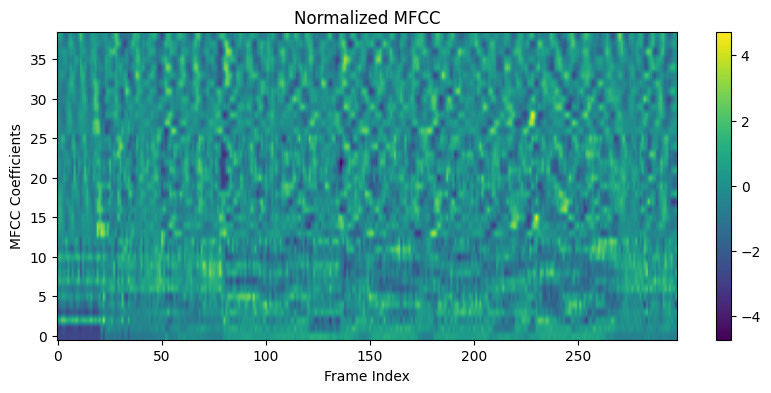

In [9]:
# 堆叠特征：[824, 39]
stacked_features = np.hstack((mfcc_features, delta1, delta2))

# CMN: 减去每个特征的平均值
cmn_features = stacked_features - np.mean(stacked_features, axis=0)

# CVN: 除以每个特征的标准偏差
cvn_features = cmn_features / np.std(cmn_features, axis=0)

plt.figure(figsize=(10, 4))
plt.imshow(cvn_features.T, aspect='auto', cmap='viridis')
plt.title('Normalized MFCC')
plt.ylabel('MFCC Coefficients')
plt.gca().invert_yaxis()  # 翻转y轴
plt.xlabel('Frame Index')
plt.colorbar()
cvn_features.shape

### 主成分分析
特征转换是用于将MFCC特征投影到一个新的、可能更低维的空间。这通常通过主成分分析（PCA）或线性判别分析（LDA）来实现。

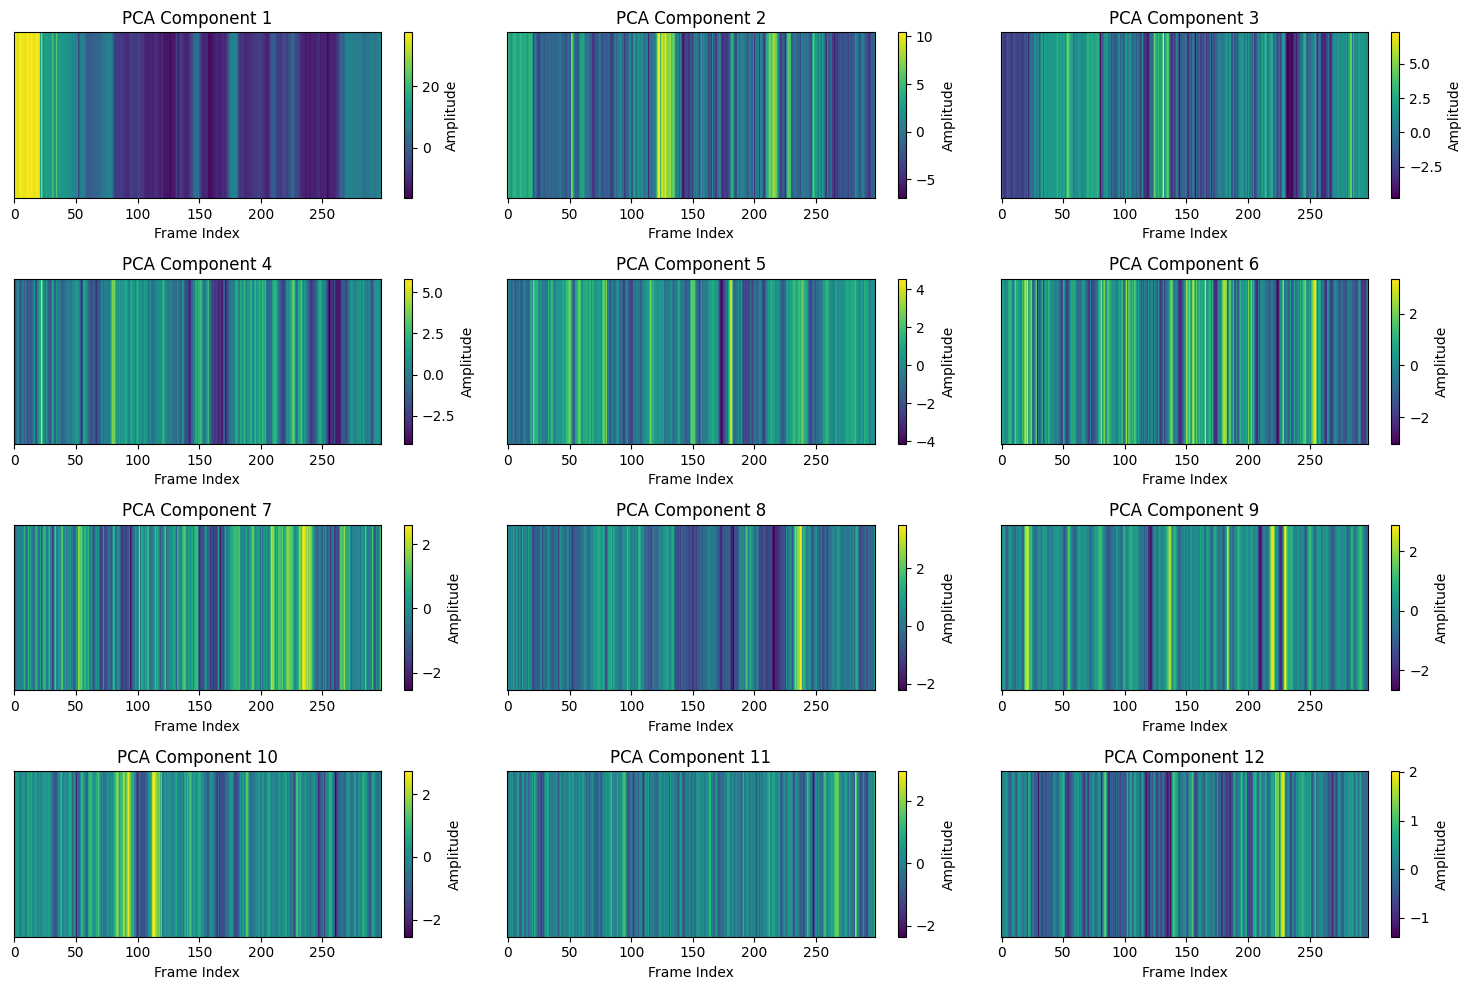

In [10]:
from sklearn.decomposition import PCA

def feature_transformation(features, n_components=12):
    
    pca = PCA(n_components=n_components)
    transformed_features = pca.fit_transform(features)
    
    return transformed_features

# 对堆叠的特征进行转换
transformed_features = feature_transformation(stacked_features)

plt.figure(figsize=(15, 10))

for i in range(transformed_features.shape[1]):
    plt.subplot(4, 3, i + 1)  # 为12个组件我们创建4x3的subplot布局
    plt.imshow(transformed_features[:, i].reshape(-1, 1).T, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitude', orientation='vertical')
    plt.title(f'PCA Component {i+1}')
    plt.xlabel('Frame Index')
    plt.yticks([])  

plt.tight_layout()
plt.show()

